In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
warnings.filterwarnings('ignore')

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
                'marital-status', 'occupation', 'relationship', 'race', 'gender',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']


adult_df = pd.read_csv("data/adult_training.csv",
                      delimiter=",",
                      skipinitialspace=True,
                      names = column_names,
                      dtype=None)

adult_test_df = pd.read_csv("data/adult_training.csv",
                      delimiter=",",
                      skipinitialspace=True,
                      names = column_names,
                      dtype=None)

from sklearn.model_selection import train_test_split
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix



from sklearn.model_selection import train_test_split
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier

from joblib import dump, load
from sklearn.model_selection import cross_val_score
import sys

from pandas.tools.plotting import table
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import l1_min_c


In [2]:
def adult_preprocess(df, balanced=False, impute=False):
    """adult_preprocess(df, balanced=False, impute=False)
            balanced: will sample an even amount of data from each
    
            impute:
                Imputes missing data using random forest,
                or removes rows with missing data
                
        expands categorical data returns X and Y arrays"""
    #drop columns
    drop_columns = ["fnlwgt"]
    df = df.drop(drop_columns , axis=1)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import tree
    
    
    if impute:
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df.workclass
        impute_df.drop(columns = ['workclass'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df.workclass.values == '?')].copy()
        
        train_data = impute_df[(df.workclass.values != '?')].copy()
        train_label = impute_labels[(df.workclass.values != '?')]
     
        random_forest = RandomForestClassifier(n_estimators=10)
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df.workclass.values == '?'),'workclass'] = random_forest_pred
        
        #repeat for occupation
        
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df.occupation
        impute_df.drop(columns = ['occupation'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df.occupation.values == '?')].copy()
        
        train_data = impute_df[(df.occupation.values != '?')].copy()
        train_label = impute_labels[(df.occupation.values != '?')]
     
        random_forest = RandomForestClassifier(n_estimators=10)
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df.occupation.values == '?'),'occupation'] = random_forest_pred
        
        # repeat for native-country
        
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df['native-country']
        impute_df.drop(columns = ['native-country'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df['native-country'].values == '?')].copy()
        
        train_data = impute_df[(df['native-country'].values != '?')].copy()
        train_label = impute_labels[(df['native-country'].values != '?')]
     
        random_forest = tree.DecisionTreeClassifier()
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df['native-country'].values == '?'),'native-country'] = random_forest_pred    
    else:
        # remove rows with '?'s
        df = df[(df != '?').all(1)]
    
    # convert categorical data into one-hot
    df_one_hot = pd.get_dummies(df)
    
    # sample equal number of plus and minus
    if balanced:
        # find number of income > $50k
        sample_number = len(df_one_hot[df_one_hot['income_>50K'] == 1])
        df_over_50k = df_one_hot[df_one_hot['income_>50K'] == 1].sample(n=sample_number, random_state=0)
        df_under_50k = df_one_hot[df_one_hot['income_>50K'] == 0].sample(n=sample_number, random_state=0)
        frames = [df_over_50k, df_under_50k]
        df_clean = pd.concat(frames)
    else:
        df_clean = df_one_hot
    
    #randomize data order
    df_clean = df_clean.sample(frac=1)
    
    # split into inputs and targets
    X = df_clean.iloc[:,0:-2].values
    Y = df_clean.loc[:,'income_>50K'].values
    
    return X, Y

In [3]:
def performance_metrics(y_true, y_pred):
    
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    false_pos = FP/(FP+TN)
    
    metrics = {}
    metrics['accuracy'] =  accuracy
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f_measure'] = f_measure
    metrics['sensitivity'] = sensitivity
    metrics['specificity'] = specificity
    metrics['error_rate'] = error_rate
    metrics['false_pos'] = false_pos
    
    return metrics

In [4]:
X, Y = adult_preprocess(adult_df, balanced=False, impute=True)
scaler = StandardScaler()  # Default behavior is to scale to [0,1]
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0)

X_test, Y_test = adult_preprocess(adult_test_df, balanced=False, impute=True)
X_test = scaler.fit_transform(X_test)

In [10]:

cs = l1_min_c(X_train,Y_train , loss='log') * np.logspace(0, 7, 16)

In [31]:
ovl_log = pd.DataFrame()
for c in cs:
    
    classifier = LogisticRegression(penalty='l1', solver='saga',tol=1e-6,C=c)
    classifier.fit(X_train,Y_train)
    
    predict_test = classifier.predict(X_test)
        
    log_test = performance_metrics(Y_test, predict_test)

    temp_log = pd.DataFrame([log_test], 
                         index = ['C = ' + str(round(c, 4))])
    
    ovl_log = pd.concat([ovl_log,temp_log])

In [32]:
ovl_log.sort_values(by = ['f_measure', 'accuracy'], ascending = False, inplace = True)
display(ovl_log.round(4))

,accuracy,error_rate,f_measure,false_pos,precision,recall,sensitivity,specificity
C = 6.8744,0.8514,0.1486,0.6611,0.0694,0.7333,0.6018,0.6018,0.9306
C = 20.1326,0.8514,0.1486,0.6611,0.0694,0.7333,0.6018,0.6018,0.9306
C = 172.6769,0.8514,0.1486,0.6611,0.0694,0.7334,0.6017,0.6017,0.9306
C = 505.7093,0.8514,0.1486,0.6611,0.0694,0.7334,0.6017,0.6017,0.9306
C = 1481.0427,0.8514,0.1486,0.6611,0.0694,0.7334,0.6017,0.6017,0.9306
C = 58.9614,0.8514,0.1486,0.6610,0.0694,0.7333,0.6017,0.6017,0.9306
C = 2.3473,0.8513,0.1487,0.6608,0.0694,0.7332,0.6015,0.6015,0.9306
C = 0.8015,0.8512,0.1488,0.6605,0.0695,0.7329,0.6011,0.6011,0.9305
C = 0.2737,0.8512,0.1488,0.6602,0.0691,0.7336,0.6002,0.6002,0.9309
C = 0.0934,0.8510,0.1490,0.6591,0.0688,0.7338,0.5981,0.5981,0.9312


In [33]:
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax



['index' 'accuracy' 'error_rate' 'f_measure' 'false_pos' 'precision'
 'recall' 'sensitivity' 'specificity']
['Logistic Regression' 'accuracy' 'error_rate' 'f_measure' 'false_pos'
 'precision' 'recall' 'sensitivity' 'specificity']


,Logistic Regression,accuracy,error_rate,f_measure,false_pos,precision,recall,sensitivity,specificity
0,C = 6.8744,0.851417,0.148583,0.661110,0.069417,0.733333,0.601837,0.601837,0.930583
1,C = 20.1326,0.851417,0.148583,0.661110,0.069417,0.733333,0.601837,0.601837,0.930583
2,C = 172.6769,0.851417,0.148583,0.661062,0.069377,0.733406,0.601709,0.601709,0.930623
3,C = 505.7093,0.851417,0.148583,0.661062,0.069377,0.733406,0.601709,0.601709,0.930623
4,C = 1481.0427,0.851417,0.148583,0.661062,0.069377,0.733406,0.601709,0.601709,0.930623
5,C = 58.9614,0.851387,0.148613,0.661016,0.069417,0.733292,0.601709,0.601709,0.930583
6,C = 2.3473,0.851325,0.148675,0.660828,0.069417,0.733209,0.601454,0.601454,0.930583
7,C = 0.8015,0.851172,0.148828,0.660454,0.069498,0.732856,0.601071,0.601071,0.930502
8,C = 0.2737,0.851233,0.148767,0.660213,0.069134,0.733593,0.600179,0.600179,0.930866
9,C = 0.0934,0.850987,0.149013,0.659078,0.068811,0.733844,0.598138,0.598138,0.931189


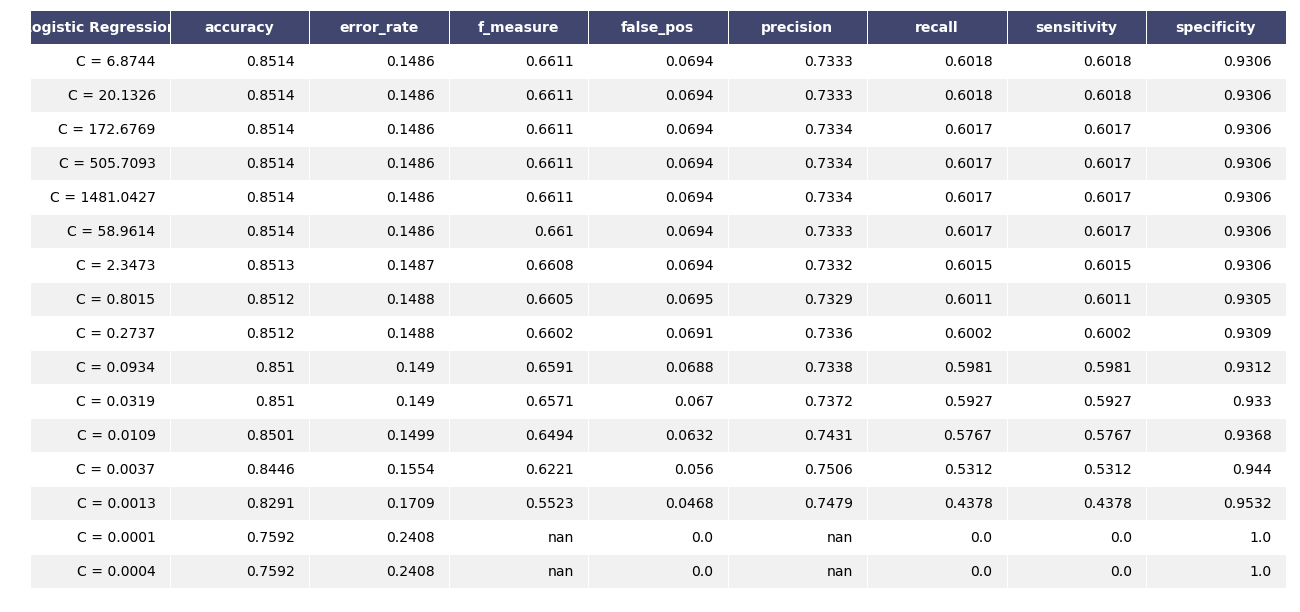

In [40]:
tmp_dataframe = ovl_log.copy()
tmp_dataframe.reset_index(inplace = True)
print(tmp_dataframe.columns.values)
tmp_dataframe.rename(columns={"index" : "Logistic Regression"},inplace=True)
print(tmp_dataframe.columns.values)
display(tmp_dataframe)
render_mpl_table(tmp_dataframe.round(4), header_columns=0, col_width=2.5)
plt.savefig("log_table.png")